<span style="font-size: 14pt">MIPT, Advanced ML, Autumn 2017</span>

<span style="font-size: 16pt"> HW #3: ARIMAX, Compositions

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

**Дополнительный материал для выполнения дз**:
- Магнус Я.Р., Катышев П.К., Пересецкий А.А. Эконометрика. Начальный курс., глава 11
- Лукашин Ю.П. Адаптивные методы краткосрочного прогнозирования временных рядов. Финансы и статистика. 2003, главы 1,4,5,7.

**Оформление дз**: 
- Присылайте выполненное задание на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall <номер_группы> <фамилия>``, к примеру -- ``ML2017_Aut_fall 401 ivanov``
- Выполненное дз сохраните в файл ``<фамилия>_<группа>_task<номер>.ipnb``, к примеру -- ``ivanov_401_task1.ipnb``

**Вопросы**:
- Присылайте вопросы на почту ``ml.course.mipt@gmail.com``
- Укажите тему письма в следующем формате ``ML2017_Aut_fall Question <Содержание вопроса>``

<span style="color:red; font-size: 14pt;"> DEADLINE: 10 October 2017 23:59:59 </span>

--------
- **PS1**: Мы используем автоматические фильтры, и просто не найдем ваше дз, если вы не аккуратно его подпишите.
- **PS2**: Напоминаем, что дедлайны жесткие, письма пришедшие после автоматически удаляются =( чтобы соблазна не было 


<h1 align="center">Check Questions (20%)</h1> 

Ответе на вопросы своими словами (загугленный материал надо пересказать), ответ обоснуйте (напишите и ОБЪЯСНИТЕ формулки если потребуется), если не выходит, то вернитесь к лекции дополнительным материалам:

**Вопрос 1** Опишите ситуацию (аргументированно), в котором композиция Adaptive Selection будет прогнозировать хуже, чем лучший из базовых алгоритмов.

**Ответ**
* Адаптивная селекция на каждом шаге выбирает множество алгоритмов, взвешенный ошибки которых отличаются от ошибки лучшего алгоритма не больше, чем на какой-то $\epsilon$, а в ответе выдаёт среднее результатов лучших алгоритмов. Но если в какой-то момент времени плохой алгоритм случайно даст хороший результат, то адаптивная селекция может его выбрать, и итоговое предсказание может получиться хуже, чем у лучшего алгоритма. 

**Вопрос 2**  Опишите ситуацию (аргументированно), в котором композиция Adaptive Composition будет прогнозировать хуже, чем лучший из базовых алгоритмов.

**Ответ**
* Адаптивная композиция в качестве прогнозов выдаёт взвешенную сумму результатов базовых алгоритмов, веса отнормированы и вычисляются исходя из взвешенной ошибки алгоритма - чем больше ошибка алгоритма, тем меньше будет вес его результата в конечном предсказании. Проблема та же, что и в адаптивной селекции, если какой-то плохой алгоритм случайно будет попадать в топ на протяжении некоторого времени, то прогноз может получиться хуже, чем у лучшего алгоритма 

**Вопрос 3** Что значит смешиваемость (mixability) игры (в теории агрегирующего алгоритма)?

<Ответ>

**Вопрос 4**: Верно ли, что для смешиваемых игр процесс потерь любой композиции (любого алгоритма) будет расти со временем (с ростом $t$) не быстрее, чем процесс потерь лучшего из базовых алгоритмов? Если нет - приведит пример, когда это не так.

### $$ \mathrm{Loss}_{Composition}(T)\leq \inf\limits_{BA} \mathrm{Loss}_{BA}(T)+C$$

<Ответ>

<h1 align="center">2. Contest: electricity comsumption contest (80%)</h1>
Take part in <a href='https://www.kaggle.com/t/de102b28cae74e6ead7492ff12efbc63'>contest</a>.
<span style='color:red'> You need to send the final code that is used for building forecast.</span>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import math

%matplotlib inline

### Анализируем данные

In [3]:
data = pd.read_csv('train.csv', sep=',', decimal='.', parse_dates=True, dayfirst=True, index_col='Date')
data.index.names=['Timestamp']

In [3]:
data.head()

,ID,tsID,ACTUAL,Temp,Saturday,Sunday
Timestamp,,,,,,
2010-01-01,1,4,35489.95,-0.9,0.0,1
2010-01-02,2,4,35413.59,-0.1,1.0,0
2010-01-03,3,4,34802.67,-3.9,0.0,1
2010-01-04,4,4,36003.84,-13.7,0.0,1
2010-01-05,5,4,37622.96,-16.9,0.0,1


In [4]:
data.dtypes

ID            int64
tsID          int64
ACTUAL      float64
Temp        float64
Saturday    float64
Sunday        int64
dtype: object

#### Посмотрим, как выглядит один из рядов

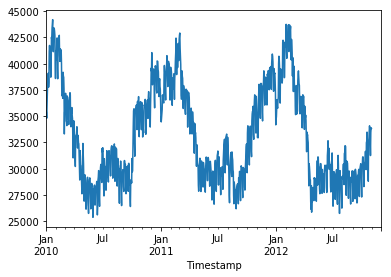

In [19]:
data.loc[data.tsID == 4, 'ACTUAL'].plot()

In [20]:
data['year'] = data.index.year

### Проанализируем конкретный временного ряда c $id=4$

In [21]:
forecast_hor = 30

In [22]:
ts_id = 4

In [23]:
cur_ts = data.loc[data.tsID == ts_id]

#### Сколько наблюдений за конкретный год

In [24]:
print("Количество наблюдений за 2010 год {}".format(len(cur_ts[cur_ts.year == 2010])))
print("Количество наблюдений за 2011 год {}".format(len(cur_ts[cur_ts.year == 2011])))
print("Количество наблюдений за 2012 год {}".format(len(cur_ts[cur_ts.year == 2012])))

Количество наблюдений за 2010 год 365
Количество наблюдений за 2011 год 365
Количество наблюдений за 2012 год 335


In [25]:
cur_ts.head()

,ID,tsID,ACTUAL,Temp,Saturday,Sunday,year
Timestamp,,,,,,,
2010-01-01,1,4,35489.95,-0.9,0.0,1,2010
2010-01-02,2,4,35413.59,-0.1,1.0,0,2010
2010-01-03,3,4,34802.67,-3.9,0.0,1,2010
2010-01-04,4,4,36003.84,-13.7,0.0,1,2010
2010-01-05,5,4,37622.96,-16.9,0.0,1,2010


##### Посмотрим, есть ли зависимость от темпертаруры

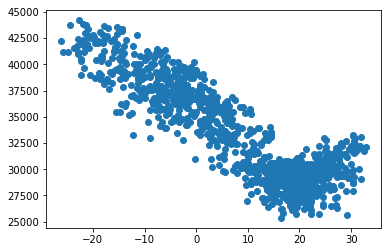

In [26]:
plt.scatter(cur_ts['Temp'], cur_ts['ACTUAL'])

#####  кажется, что зависимость есть, 

##### Оставляем только наблюдения, где мы знаем значения, остальное - тест. В прогнозировании будем учитывать только значение потребления энергии

In [27]:
cur_ts = cur_ts[['ACTUAL', 'Temp']]
cur_ts_test = cur_ts.tail(30)
cur_ts = cur_ts[:-30]

In [28]:
cur_ts.tail()

,ACTUAL,Temp
Timestamp,,
2012-10-27,32194.01,4.0
2012-10-28,31246.77,5.0
2012-10-29,33454.83,10.5
2012-10-30,33894.82,8.8
2012-10-31,33838.25,10.5


##### Посмотрим на декомпозицию нашего ряда по неделям

In [34]:
import statsmodels.api as sm

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


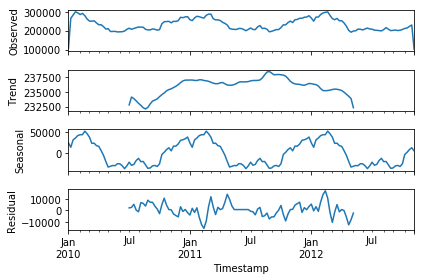

In [35]:
res = sm.tsa.seasonal_decompose(cur_ts['ACTUAL'].resample("W").sum())
resplot = res.plot()

##### Видно, что есть тренд и сезонность, также есть и годовая сезонность

In [36]:
# заполним тестовые данные нулями
cur_ts_test.fillna(0, inplace=True)

## Попробуем прогнозировать наши временные ряды чем-нибудь простым, например, линейной регрессией. 
* В качестве признаков будем использовать $7$ предыдущих значений ряда, тк есть недельная сезонность

In [37]:
"""создаёт матрицу - объекты-признаки, 
    признаки - наблюдения на предыдущих n_in шагах
    объекты - наблюдение на текущем шаге"""
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

#### Создадим матрицу объекты - признаки

In [38]:
reframed = series_to_supervised(cur_ts, n_in=7, n_out=1)
reframed.head()

,var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
Timestamp,,,,,,,,,,,,,,,,
2010-01-08,35489.95,-0.9,35413.59,-0.1,34802.67,-3.9,36003.84,-13.7,37622.96,-16.9,38248.29,-16.3,38368.36,-17.5,39097.83,-13.2
2010-01-09,35413.59,-0.1,34802.67,-3.9,36003.84,-13.7,37622.96,-16.9,38248.29,-16.3,38368.36,-17.5,39097.83,-13.2,37758.88,-6.0
2010-01-10,34802.67,-3.9,36003.84,-13.7,37622.96,-16.9,38248.29,-16.3,38368.36,-17.5,39097.83,-13.2,37758.88,-6.0,38223.03,-7.8
2010-01-11,36003.84,-13.7,37622.96,-16.9,38248.29,-16.3,38368.36,-17.5,39097.83,-13.2,37758.88,-6.0,38223.03,-7.8,41143.29,-14.5
2010-01-12,37622.96,-16.9,38248.29,-16.3,38368.36,-17.5,39097.83,-13.2,37758.88,-6.0,38223.03,-7.8,41143.29,-14.5,41738.98,-12.2


In [39]:
reframed.drop(reframed.columns[[-1]], axis=1, inplace=True)

In [40]:
reframed.shape

(1028, 15)

#### Разделим на тренировочную и тестовую выборки

In [42]:
values = reframed.values
n_train_days = math.ceil(len(reframed)*0.8)
train = values[:n_train_days, :]
test = values[n_train_days:, :]

#### Разделим на множества объектов и ответов к ним

In [44]:
train_X, train_y = train[:, :-1], train[:, -1:]
test_X, test_y = test[:, :-1], test[:, -1]

In [45]:
print(train_X.shape, train_y.shape, test_X.shape)

(823, 14) (823, 1) (205, 14)


#### Собственно применяем линейную регрессию

In [46]:
from utils import qualityMAPE
from sklearn.linear_model import LinearRegression

In [47]:
def MAPE(x, y):
    qlt = (abs(x-y)/x)
    return qlt.mean()*100

#### Обучаем веса

In [48]:
lr = LinearRegression()
lr.fit(train_X.squeeze(), train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### Делаем предсказание

In [49]:
# make a prediction
lr_yhat = lr.predict(test_X.squeeze())
lr_yhat.shape

(205, 1)

#### Посмотрим на качество

In [50]:
mape = MAPE(test_y, lr_yhat)
print('Test MAPE: %.3f' % (mape))

Test MAPE: 6.212


#### Нарисуем график

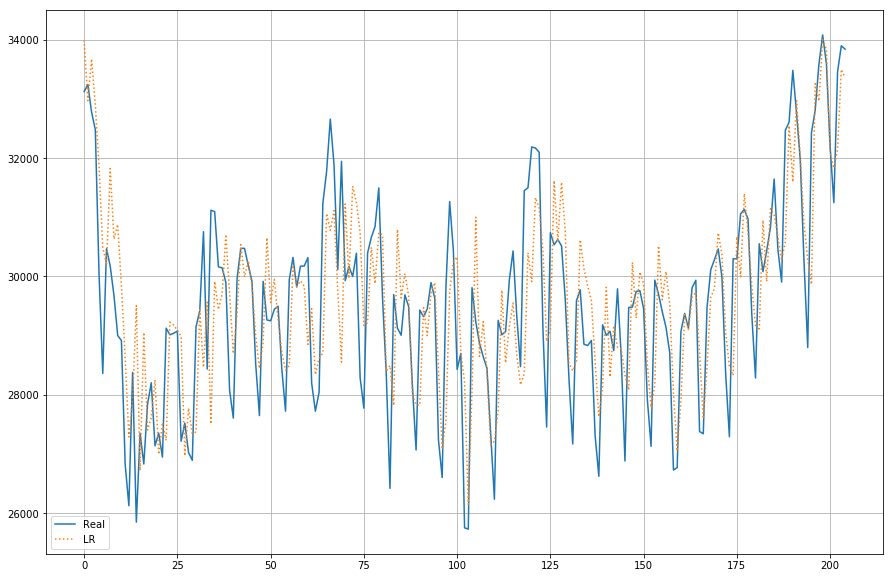

In [51]:
plt.figure(figsize=(15,10))
plt.plot(np.array(test_y), label='Real')
# plt.plot(inv_yhat, '-.', linewidth=2, label='Predicted')
plt.plot(lr_yhat, ':', label='LR')
plt.grid()
plt.legend()

## Как будет предсказывать модель на 30 дней вперёд
* Проделаем те же действия как и для предсказания на 1 день вперёд, только для предсказания на 30 дней вперёд будем использовать нами же предсказанные результаты, то есть для предсказания например на 2 дня вперёд в признаки будем включать наше же предсказание на 1 день вперёд

In [83]:
cur_ts = data.loc[data.tsID == 4]
cur_ts = cur_ts[['ACTUAL', 'Temp']][:-30]

In [117]:
from sklearn.preprocessing import MinMaxScaler

##### Отмасштабируем данные в отрезок от нуля до еденицы

In [118]:
scaler = MinMaxScaler()
cur_ts_scaled = scaler.fit_transform(cur_ts.values)

In [119]:
reframed = series_to_supervised(cur_ts_scaled, n_in=7, n_out=1)

In [120]:
reframed.head()

,var1(t-7),var2(t-7),var1(t-6),var2(t-6),var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t),var2(t)
7,0.537751,0.427844,0.533697,0.441426,0.501260,0.376910,0.565036,0.210526,0.651004,0.156197,0.684206,0.166384,0.690582,0.146010,0.729313,0.219015
8,0.533697,0.441426,0.501260,0.376910,0.565036,0.210526,0.651004,0.156197,0.684206,0.166384,0.690582,0.146010,0.729313,0.219015,0.658221,0.341256
9,0.501260,0.376910,0.565036,0.210526,0.651004,0.156197,0.684206,0.166384,0.690582,0.146010,0.729313,0.219015,0.658221,0.341256,0.682865,0.310696
10,0.565036,0.210526,0.651004,0.156197,0.684206,0.166384,0.690582,0.146010,0.729313,0.219015,0.658221,0.341256,0.682865,0.310696,0.837918,0.196944
11,0.651004,0.156197,0.684206,0.166384,0.690582,0.146010,0.729313,0.219015,0.658221,0.341256,0.682865,0.310696,0.837918,0.196944,0.869546,0.235993


In [121]:
values = reframed.values
n_test_days = 30

In [122]:
train = values[:-n_test_days, :]
test = values[-n_test_days:, :]
test.shape

(30, 16)

In [123]:
train_X, train_y = train[:, :-2], train[:, -2:]
test_X, test_y = test[:, :-2], test[:, -2:]

In [125]:
train_X.shape

(998, 14)

In [126]:
import warnings

In [127]:
%%time
n_days = 30
y_pred = []

warnings.filterwarnings('ignore')

for day in range(n_days):
    lr = LinearRegression()
    
    # train_y содержит температуру и потребление, нам нужно только потребление
    tr_y = np.transpose(train_y)
    tr_y = tr_y[0][:, None]
    lr.fit(train_X, tr_y)
    
    # делаем предсказание для данных, достаём температуру и потребление
    shift_row = np.roll(train_X[-1], -2)
    shift_row[-2] = train_y[-1][0]
    shift_row[-1] = train_y[-1][1]
    lr_yhat = lr.predict(shift_row)

    # делаем обратное преобразование
    lr_inv_yhat = np.concatenate((lr_yhat, 
                                  np.zeros((len(lr_yhat), 1))), axis=1)
    lr_inv_yhat = scaler.inverse_transform(lr_inv_yhat)
    lr_inv_yhat = lr_inv_yhat[:,0]

    # добавляем результаты предыдущих предсказаний
    train_X = np.vstack((train_X, shift_row))
    train_y = np.vstack((train_y, [lr_yhat[0][0], test_y[day][1]]))
    
    y_pred.append(lr_inv_yhat)
#     print('----------------------------------------------------------------------------------------------------')

Wall time: 34.1 ms


#### Смотрим на качество

In [128]:
test_y = cur_ts['ACTUAL'][-30:]

In [129]:
mape = MAPE(y_pred, np.array(test_y))

print('Test MAPE: %.5f' % (mape))

Test MAPE: 5.14675


#### Нарисуем график

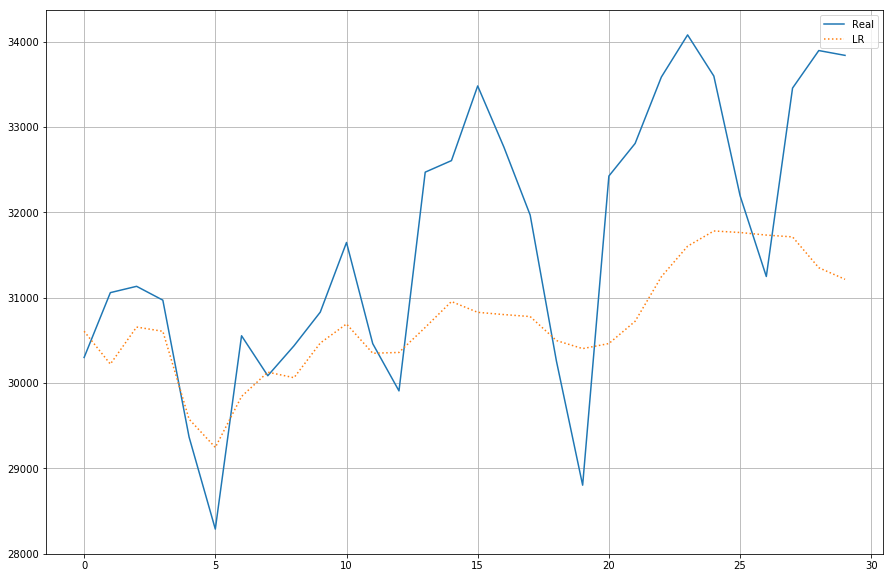

In [130]:
plt.figure(figsize=(10,7))
plt.plot(np.array(test_y), label='Real')
plt.plot(y_pred, ':', label='LR')
plt.grid()
plt.legend()

## Делаем то же самое для всех временных рядов

In [134]:
forecast_hor = 30
tsID = np.unique(data.tsID)

In [135]:
"""Делает то же самое, что мы делали для предсказания на 30 дней вперёд"""
def get_prediction(train_X, train_y, test_y, scaler, n_days=30):
    y_pred = []

    warnings.filterwarnings('ignore')

    for day in range(n_days):
        lr = LinearRegression()
        tr_y = np.transpose(train_y)
        tr_y = tr_y[0][:, None]
        lr.fit(train_X, tr_y)

        shift_row = np.roll(train_X[-1], -2)
        shift_row[-2] = train_y[-1][0]
        shift_row[-1] = train_y[-1][1]
        lr_yhat = lr.predict(shift_row)

        lr_inv_yhat = np.concatenate((lr_yhat, 
                                      np.zeros((len(lr_yhat), 1))), axis=1)
        lr_inv_yhat = scaler.inverse_transform(lr_inv_yhat)
        lr_inv_yhat = lr_inv_yhat[:,0]

        train_X = np.vstack((train_X, shift_row))
        train_y = np.vstack((train_y, [lr_yhat[0][0], test_y[day][1]]))

        y_pred.append(lr_inv_yhat)
    return y_pred

In [136]:
res_table = pd.DataFrame()

##### Всё то же проделываем для всех временных рядов, это можно было делать не в цикле, ну да ладно...

In [137]:
%%time
for ts_id in tsID:
    scaler_train, scaler_test = MinMaxScaler(), MinMaxScaler()
    
    """---------------Считывание данных----------------------------"""
    # вытаскиваем ряд с конкретным id
    cur_ts = data.loc[data.tsID == ts_id]
    
     # вытаскиваем индексы
    cur_ts_forecast_id = cur_ts['ID'][-forecast_hor:]
    
    # оставляем значения только 'ACTUAL', 'Temp'
    cur_ts = cur_ts[['ACTUAL', 'Temp']]
    
    # разделяем на данные, которые не предсказаны
    cur_ts_test = cur_ts.tail(30)
    cur_ts = cur_ts[:-30]
    cur_ts_test.fillna(0, inplace=True)
    
    """---------------Препроцессинг данных----------------------------"""
    # масштабируем данные в отрезок (0; 1)
    cur_ts_scaled = scaler_train.fit_transform(cur_ts.values)
    cur_ts_test_scaled = scaler_test.fit_transform(cur_ts_test.values)
    
    # создаём матрицу объекты - признаки для тренировочной выборки
    train_reframed = series_to_supervised(cur_ts_scaled, n_in=7, n_out=1)
    
    # делим на объекты - признаки
    train_values = train_reframed.values
    train_X, train_y = train_values[:, :-2], train_values[:, -2:]
    
    """---------------Предсказание----------------------------"""
    # получаем предсказание
    y_pred = get_prediction(train_X, train_y, cur_ts_test_scaled, scaler_train, n_days=30)
    
    """---------------Итоговая таблица----------------------------"""
    res = []
    # трансформируем его в нормальный вид
    for ind in range(len(y_pred)):
        res.append([cur_ts_forecast_id[ind], y_pred[ind][0]])
        
    res_table = res_table.append(pd.DataFrame(res))

Wall time: 2.92 s


#### Формируем итоговую таблицу

In [139]:
res_table.columns = ['ID', 'PREDICTED']
res_table.to_csv('result.csv', index=False)

In [140]:
res_table.head()

,ID,PREDICTED
0,16707,107372.952663
1,16708,107206.895458
2,16709,101806.500400
3,16710,100122.893408
4,16711,103503.592089


# Экспоненциальное сглаживание
* Видно, что у данных есть ярко выраженная сезонность, попробуем использовать модель Винтерса для предсказания

In [4]:
from utils import qualityMAPE

#### Модель Винтерса: 
$$\hat{y}=l_t+s_{t-p};$$
$$l_t = \alpha (y_t - s_{t-p}) + (1-\alpha) l_{t-1};$$
    $$ s_t = \gamma (y_t-l_t) + (1-\gamma) s_{t-p}$$

In [5]:
def WintersExponentialSmoothing(x, h, Params):
    T = len(x)
    alpha = Params['alpha']
    delta = Params['delta']
    p = Params['seasonality_period']
    
    FORECAST = [np.NaN]*(T+h)
    
    l= np.NaN
    s= [np.NaN]*(T+h)
    
    for cntr in range(T):
        if not math.isnan(x[cntr]):
            if math.isnan(l):
                l = np.array(x[:(cntr+1)]).mean()
 
            if math.isnan(s[cntr-p]) or cntr-p < 0:
                s[cntr-p] = x[cntr] / l
            
            l_prev = l
            l = alpha*(x[cntr] - s[cntr-p])+(1-alpha)*l_prev
            s[cntr] = delta*(x[cntr]-l_prev)+(1-delta)*s[cntr - p]
           
            FORECAST[cntr+h] = l + s[cntr-p+(h%p)]
    return FORECAST

In [6]:
"""Стороит предсказание"""
def BuildForecast(h, ts, ParamsArray):
    FRC_TS = dict()
    for p in ParamsArray:
        frc = WintersExponentialSmoothing(ts, h, p)
        FRC_TS['%s' % p] = frc
    return FRC_TS

In [7]:
"""Отрисовка графика"""
def plotForecast(cur_ts, FRC):
    plt.figure()
    plt.plot(np.array(cur_ts[-30:]))
    plt.plot(FRC[-60:-30], 'r')
    plt.xlabel('Time ticks')
    plt.ylabel('TS values')
    plt.legend()
    plt.show()

In [8]:
def MAPE(x, y):
    qlt = (abs(x-y)/abs(x))
    return qlt.mean()*100

In [9]:
"""Выбор наилучших параметров"""
def best_param(cur_ts, FRC):
    # compare parameters
    Quality = pd.DataFrame(index = cur_ts.index, columns = FRC.keys())

    ix = len(cur_ts)
    for param in sorted(Quality.columns):
        frc = FRC[param]
        Quality[param] = MAPE(cur_ts[30:ix], frc[30:ix])

    return Quality[Quality.columns].mean().sort_values()[:1]

#### Для конкретного ряда с $id=1$

In [10]:
cur_ts = data.loc[data.tsID == 1]
cur_ts = cur_ts['ACTUAL'][:-30]

#### Перебираем очень много параметров

In [11]:
DELTA = [0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ALPHA = [0.001, 0.005, 0.01, 0.05, 0.07, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.9]
SEASON = [7, 30, 365]

In [12]:
ParamsArray = [{'alpha':alpha, 'delta':delta, 'seasonality_period': season} 
                  for delta in DELTA 
                     for alpha in ALPHA
                         for season in SEASON]

#### Стоим предсказания для всех параметров

In [13]:
%%time
FRC = BuildForecast(h=30, ts=cur_ts, ParamsArray = ParamsArray)

#### Выбираем лучшее предсказание, строим график

{'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}    5.246848
dtype: float64
{'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


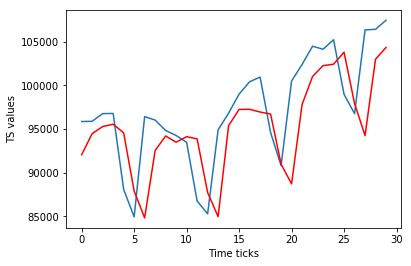

In [14]:
Quality = best_param(cur_ts, FRC)
print(Quality)
params = Quality.index[0]
print(params)
plotForecast(cur_ts, FRC[params])

#### Выглядит лучше, чем у линейной регрессии

### Для всех рядов

In [15]:
from tqdm import tqdm

In [16]:
result = []
indexes = np.unique(data.tsID)
indexes

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22], dtype=int64)

In [17]:
train_data = []
ts_id = []
for tsID in indexes:
    ts = data.loc[data.tsID == tsID]
    # вытаскиваем индексы
    ts_forecast_id = ts['ID'][-30:]
    ts_id.append(ts_forecast_id)
    # вытаскиваем данные
    ts = ts['ACTUAL'][:-30]
    train_data.append(ts)

  0%|                                                                                           | 0/22 [00:00<?, ?it/s]

0 {'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}    5.246848
dtype: float64


C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


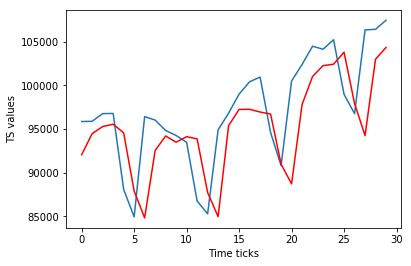

--------------------------------------------------------------------------------------------------------------


  5%|███▊                                                                               | 1/22 [00:33<11:42, 33.44s/it]

1 {'alpha': 0.9, 'delta': 0.1, 'seasonality_period': 7}    5.217986
dtype: float64


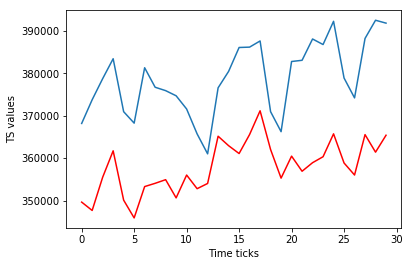

--------------------------------------------------------------------------------------------------------------


  9%|███████▌                                                                           | 2/22 [01:08<11:18, 33.92s/it]

2 {'alpha': 0.001, 'delta': 0.5, 'seasonality_period': 365}    3.098547
dtype: float64


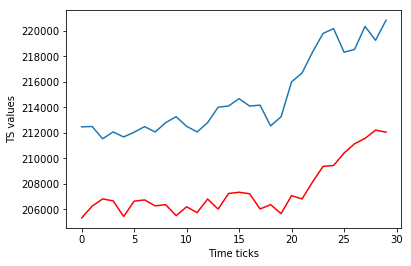

--------------------------------------------------------------------------------------------------------------


 14%|███████████▎                                                                       | 3/22 [01:43<10:49, 34.16s/it]

3 {'alpha': 0.001, 'delta': 0.8, 'seasonality_period': 365}    5.431973
dtype: float64


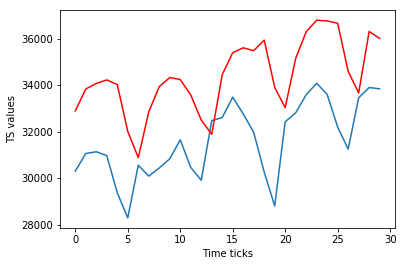

--------------------------------------------------------------------------------------------------------------


 18%|███████████████                                                                    | 4/22 [02:19<10:28, 34.92s/it]

4 {'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}    4.615353
dtype: float64


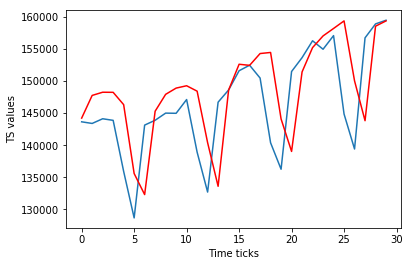

--------------------------------------------------------------------------------------------------------------


 23%|██████████████████▊                                                                | 5/22 [03:00<10:21, 36.57s/it]

5 {'alpha': 0.001, 'delta': 0.8, 'seasonality_period': 365}    7.393198
dtype: float64


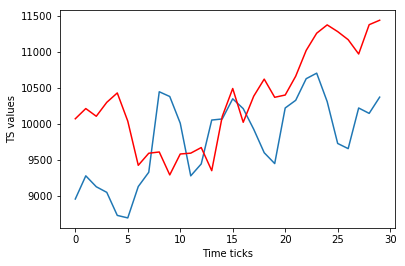

--------------------------------------------------------------------------------------------------------------


 27%|██████████████████████▋                                                            | 6/22 [03:43<10:15, 38.45s/it]

6 {'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}    8.527476
dtype: float64


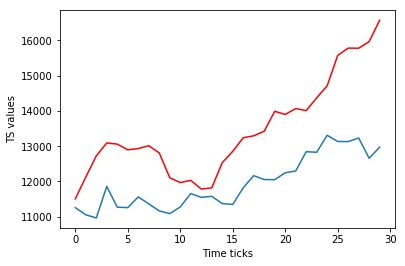

--------------------------------------------------------------------------------------------------------------


 32%|██████████████████████████▍                                                        | 7/22 [04:22<09:41, 38.79s/it]

7 {'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}    7.296904
dtype: float64


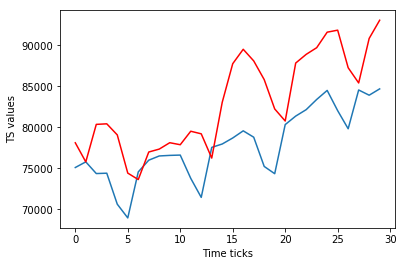

--------------------------------------------------------------------------------------------------------------


 36%|██████████████████████████████▏                                                    | 8/22 [04:59<08:53, 38.12s/it]

8 {'alpha': 0.001, 'delta': 0.8, 'seasonality_period': 365}    4.920717
dtype: float64


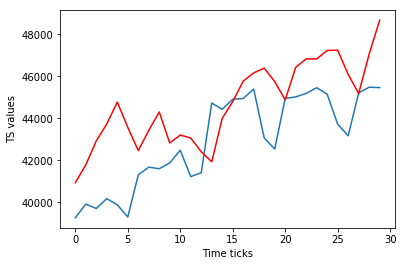

--------------------------------------------------------------------------------------------------------------


 41%|█████████████████████████████████▉                                                 | 9/22 [05:34<08:05, 37.37s/it]

9 {'alpha': 0.001, 'delta': 0.8, 'seasonality_period': 365}    6.102279
dtype: float64


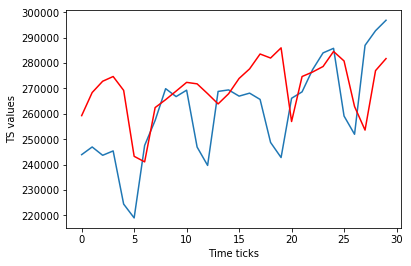

--------------------------------------------------------------------------------------------------------------


 45%|█████████████████████████████████████▎                                            | 10/22 [06:12<07:27, 37.31s/it]

10 {'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}    3.72873
dtype: float64


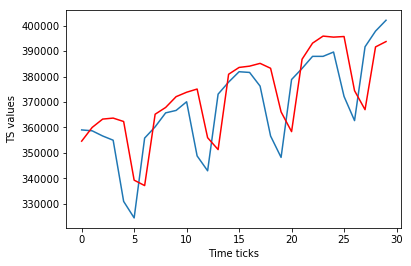

--------------------------------------------------------------------------------------------------------------


 50%|█████████████████████████████████████████                                         | 11/22 [06:47<06:44, 36.75s/it]

11 {'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}    4.585854
dtype: float64


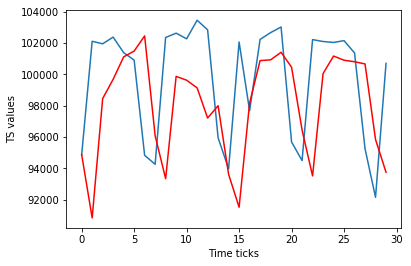

--------------------------------------------------------------------------------------------------------------


 55%|████████████████████████████████████████████▋                                     | 12/22 [07:16<05:44, 34.45s/it]

12 {'alpha': 0.005, 'delta': 0.8, 'seasonality_period': 365}    4.551253
dtype: float64


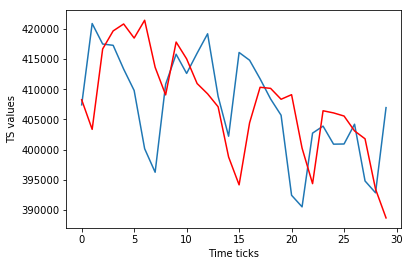

--------------------------------------------------------------------------------------------------------------


 59%|████████████████████████████████████████████████▍                                 | 13/22 [07:52<05:14, 34.95s/it]

13 {'alpha': 0.001, 'delta': 0.6, 'seasonality_period': 365}    2.741566
dtype: float64


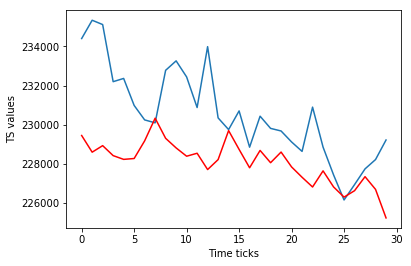

--------------------------------------------------------------------------------------------------------------


 64%|████████████████████████████████████████████████████▏                             | 14/22 [08:27<04:38, 34.76s/it]

14 {'alpha': 0.001, 'delta': 0.8, 'seasonality_period': 365}    4.633644
dtype: float64


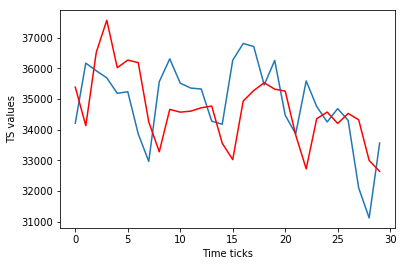

--------------------------------------------------------------------------------------------------------------


 68%|███████████████████████████████████████████████████████▉                          | 15/22 [09:05<04:10, 35.85s/it]

15 {'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}    5.137125
dtype: float64


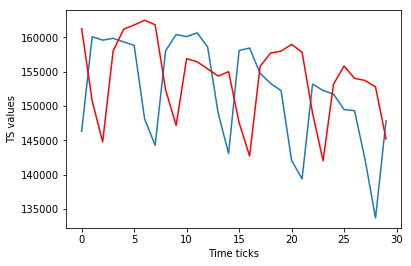

--------------------------------------------------------------------------------------------------------------


 73%|███████████████████████████████████████████████████████████▋                      | 16/22 [09:34<03:23, 33.93s/it]

16 {'alpha': 0.001, 'delta': 0.8, 'seasonality_period': 365}    6.644401
dtype: float64


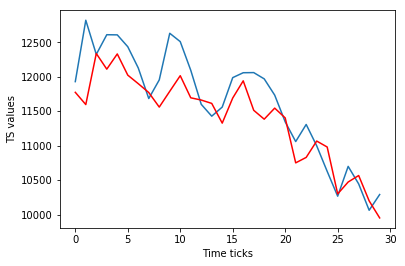

--------------------------------------------------------------------------------------------------------------


 77%|███████████████████████████████████████████████████████████████▎                  | 17/22 [10:05<02:44, 32.81s/it]

17 {'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}    6.931916
dtype: float64


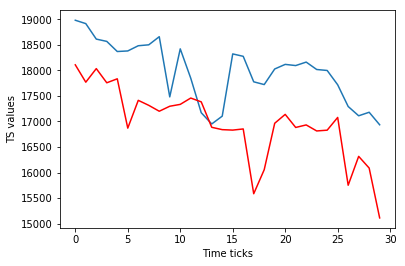

--------------------------------------------------------------------------------------------------------------


 82%|███████████████████████████████████████████████████████████████████               | 18/22 [10:33<02:05, 31.40s/it]

18 {'alpha': 0.001, 'delta': 0.7, 'seasonality_period': 365}    6.347123
dtype: float64


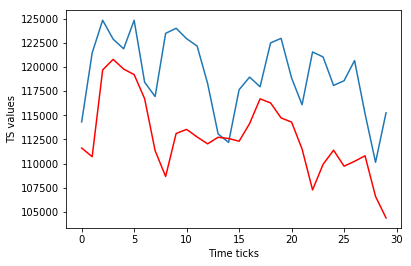

--------------------------------------------------------------------------------------------------------------


 86%|██████████████████████████████████████████████████████████████████████▊           | 19/22 [11:02<01:32, 30.89s/it]

19 {'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}    4.384547
dtype: float64


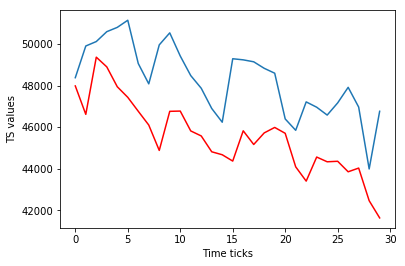

--------------------------------------------------------------------------------------------------------------


 91%|██████████████████████████████████████████████████████████████████████████▌       | 20/22 [11:34<01:02, 31.07s/it]

20 {'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}    5.380396
dtype: float64


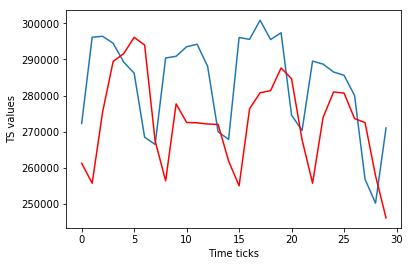

--------------------------------------------------------------------------------------------------------------


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 21/22 [12:05<00:31, 31.01s/it]

21 {'alpha': 0.001, 'delta': 0.9, 'seasonality_period': 365}    3.262968
dtype: float64


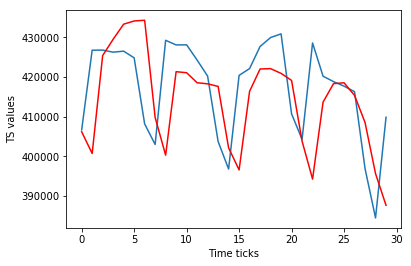

--------------------------------------------------------------------------------------------------------------


100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [12:46<00:00, 33.97s/it]


Wall time: 12min 46s


In [18]:
%%time
for tsID in tqdm(range(22)):

    FRC = BuildForecast(h=30, ts=train_data[tsID], ParamsArray = ParamsArray)
            
    Quality = best_param(train_data[tsID], FRC)
    print(tsID, Quality, sep=" ")
    params = Quality.index[0]
    plotForecast(train_data[tsID], FRC[params])
    result.append(FRC[params][-30:])      
    print("--------------------------------------------------------------------------------------------------------------")

#### Видно, что модель Винтерса подходит не для всех рядов
* возможно стоило использовать адаптивную композицию или селекцию для улучшения результатов
* возможно стоило предсказывать на один шаг вперёд, и использовать это предсказание для следующего шага

In [273]:
table = []
for res_for_ts, ids_for_ts in zip(result, ts_id):
    for res, ind in zip(res_for_ts, ids_for_ts):
        table.append([ind, res])

In [274]:
res_table = pd.DataFrame(table)

In [275]:
res_table.columns = ['ID', 'PREDICTED']

In [277]:
print(len(res_table))
res_table.head()

660


,ID,PREDICTED
0,16707,94039.244610
1,16708,93304.208821
2,16709,94165.831493
3,16710,91249.054551
4,16711,88026.845588


In [278]:
res_table.to_csv('resultES.csv', index=False)